In [1]:
!pip install pandas numpy scikit-learn matplotlib seaborn


You should consider upgrading via the 'C:\Users\Bogdan\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (
    mean_squared_error,
    accuracy_score,
    classification_report,
    confusion_matrix,
    r2_score,
)


class ModelPipeline:
    def __init__(self, dataset, target, model_type):
        """
        Initialize the pipeline with a dataset, target column, and model type.
        :param dataset: pd.DataFrame, input dataset
        :param target: str, target column name
        :param model_type: str, type of model ("classification" or "regression")
        """
        self.dataset = dataset
        self.target = target
        self.model_type = model_type
        self.models = {
            "LinearRegression": LinearRegression,
            "LogisticRegression": LogisticRegression,
            "DecisionTreeClassifier": DecisionTreeClassifier,
            "DecisionTreeRegressor": DecisionTreeRegressor,
            "RandomForestClassifier": RandomForestClassifier,
            "RandomForestRegressor": RandomForestRegressor,
        }

    def preprocess_data(self):
        """
        Preprocess the dataset: handle missing values and encode categorical features.
        """
        df = self.dataset.copy()
        df = df.drop_duplicates()

        # Fill missing values
        for column in df.select_dtypes(include=["number"]).columns:
            df[column] = df[column].fillna(df[column].mean())
        for column in df.select_dtypes(include=["object"]).columns:
            df[column] = df[column].fillna(df[column].mode()[0])

        # Encode categorical features
        df = pd.get_dummies(df, drop_first=True)
        self.dataset = df
        return df

    def visualize_data(self):
        """
        Create basic visualizations for data exploration.
        """
        print("Basic Data Information:")
        display(self.dataset.describe())
        print("\nCorrelation Matrix:")
        plt.figure(figsize=(10, 8))
        sns.heatmap(self.dataset.corr(), annot=True, cmap="coolwarm", fmt=".2f")
        plt.title("Correlation Heatmap")
        plt.show()

        # Target variable distribution
        plt.figure(figsize=(6, 4))
        if self.model_type == "classification":
            sns.countplot(x=self.target, data=self.dataset)
            plt.title("Target Variable Distribution")
            plt.show()
        else:
            sns.histplot(self.dataset[self.target], kde=True)
            plt.title("Target Variable Distribution")
            plt.show()

    def split_data(self, test_size=0.2, random_state=42):
        """
        Split the dataset into training and testing sets.
        """
        X = self.dataset.drop(columns=[self.target])
        y = self.dataset[self.target]
        return train_test_split(X, y, test_size=test_size, random_state=random_state)

    def train_model(self, model_name, X_train, y_train, **kwargs):
        """
        Train a specified model.
        :param model_name: str, name of the model to train
        :param X_train: pd.DataFrame, training features
        :param y_train: pd.Series, training target
        :param kwargs: additional parameters for the model
        :return: trained model
        """
        if model_name not in self.models:
            raise ValueError(f"Unsupported model: {model_name}")
        model = self.models[model_name](**kwargs)
        model.fit(X_train, y_train)
        return model

    def evaluate_model(self, model, X_test, y_test):
        """
        Evaluate the model and print metrics.
        """
        y_pred = model.predict(X_test)
        if self.model_type == "classification":
            print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
            print("\nClassification Report:")
            print(classification_report(y_test, y_pred))

            # Confusion matrix
            cm = confusion_matrix(y_test, y_pred)
            plt.figure(figsize=(6, 4))
            sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
            plt.title("Confusion Matrix")
            plt.xlabel("Predicted")
            plt.ylabel("Actual")
            plt.show()
        elif self.model_type == "regression":
            print(f"MSE: {mean_squared_error(y_test, y_pred)}")
            print(f"R2 Score: {r2_score(y_test, y_pred)}")

            # Actual vs Predicted scatter plot
            plt.figure(figsize=(6, 4))
            plt.scatter(y_test, y_pred, color='blue', label="Predicted", alpha=0.6)
            plt.plot(y_test, y_test, color='red', label="Actual (Ideal)", linestyle='--')
            plt.title("Actual vs Predicted")
            plt.xlabel("Actual Values")
            plt.ylabel("Predicted Values")
            plt.legend()
            plt.show()


Basic Data Information:


,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Target
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000
mean,-0.077343,1.115814,-0.020803,-0.573632,-1.732748,-1.034291,-0.568373,0.532967,0.535407,-1.522207,0.50000
std,1.851235,1.587144,2.125429,1.846328,3.065499,1.690856,1.926611,1.819767,1.793822,1.995298,0.50025
min,-5.824009,-3.551943,-7.409478,-5.283366,-11.818684,-7.173891,-8.712973,-6.080685,-7.544301,-7.596189,0.00000
25%,-1.227815,0.018902,-1.503226,-1.850948,-3.783477,-2.099031,-1.873050,-0.602306,-0.493316,-2.820320,0.00000
50%,0.100892,1.145004,-0.086342,-0.696424,-1.626836,-1.014570,-0.660203,0.579455,0.708811,-1.561151,0.50000
75%,1.148416,2.136035,1.468941,0.569953,0.281290,0.001533,0.781921,1.764738,1.657559,-0.267833,1.00000
max,5.105162,7.011590,6.336243,5.517741,8.260046,4.915352,5.445467,6.092681,6.115672,5.143041,1.00000



Correlation Matrix:


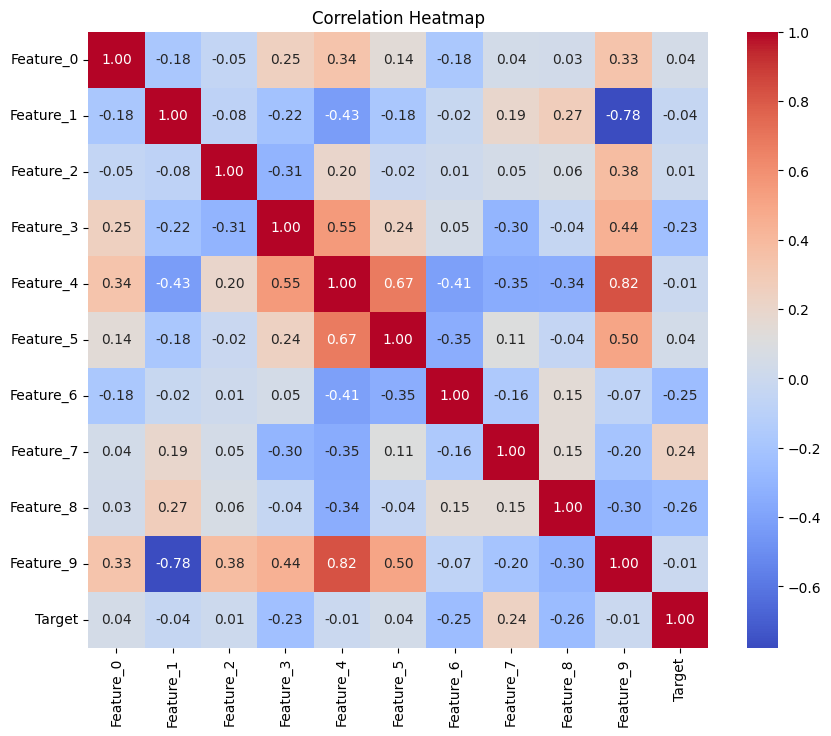

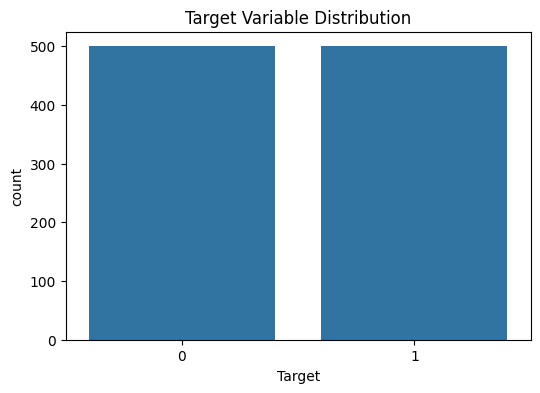


--- Logistic Regression ---
Accuracy: 0.675

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.62      0.67       106
           1       0.63      0.73      0.68        94

    accuracy                           0.68       200
   macro avg       0.68      0.68      0.67       200
weighted avg       0.68      0.68      0.67       200



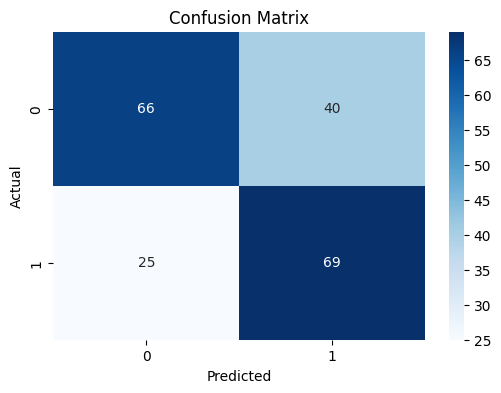

Basic Data Information:


,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Target
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,-0.002689,0.010788,-0.023104,0.005495,-0.022542,0.031292,0.038105,-0.043075,-0.029252,0.013622,3.287979
std,1.031230,1.005433,0.986846,1.030962,0.983366,1.016046,0.945284,0.983406,1.037024,1.012645,132.338175
min,-2.801912,-3.922400,-3.007632,-3.601085,-3.241267,-3.688365,-3.176704,-2.943142,-3.170426,-3.138515,-449.002017
25%,-0.744779,-0.616527,-0.650034,-0.713176,-0.702626,-0.631506,-0.559290,-0.750008,-0.749592,-0.651541,-79.406627
50%,-0.024976,0.014006,-0.003221,-0.013284,-0.015036,0.007605,0.019097,-0.001346,-0.012086,-0.012020,5.763456
75%,0.683319,0.679698,0.608861,0.696602,0.613766,0.685621,0.687027,0.638310,0.680087,0.721896,92.078615
max,3.243093,3.076860,3.377383,3.137749,3.152057,3.529055,3.852731,3.117681,3.926238,2.935658,411.221766



Correlation Matrix:


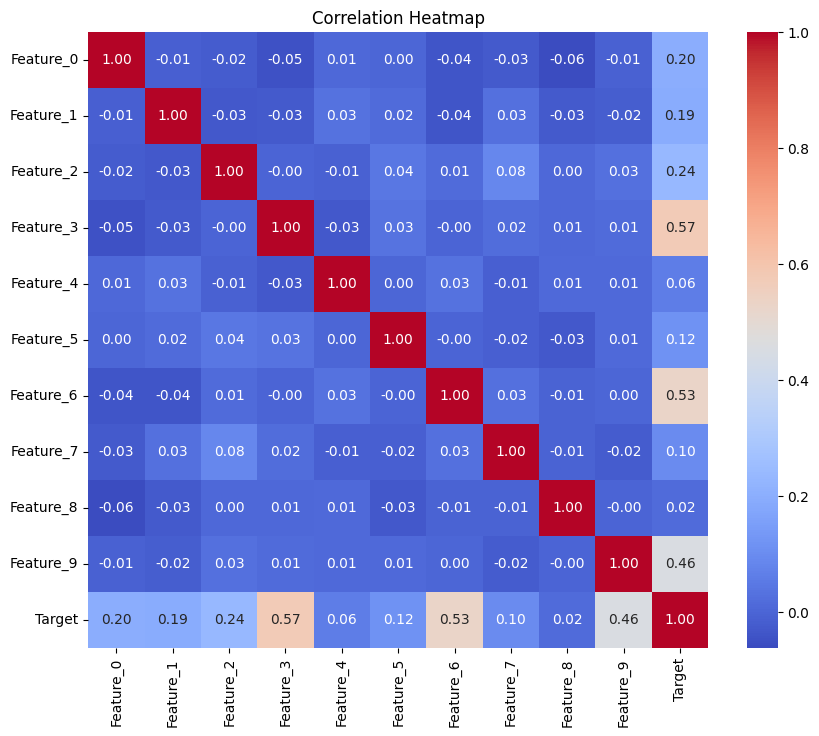

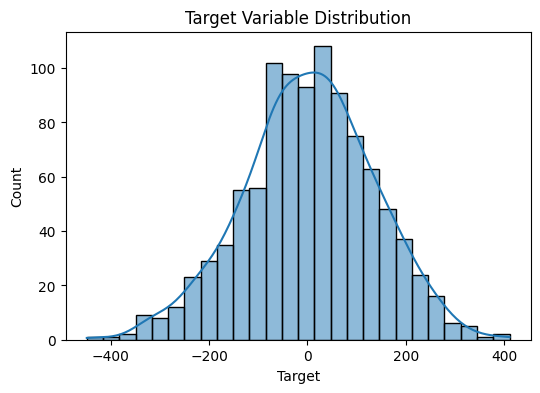


--- Random Forest Regressor ---
MSE: 2628.667768479454
R2 Score: 0.8441729560996267


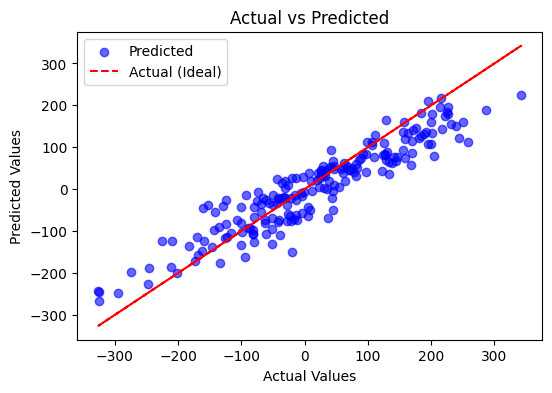

In [3]:
from sklearn.datasets import make_classification, make_regression

# Example for classification
X_class, y_class = make_classification(
    n_samples=1000, n_features=10, n_informative=8, n_redundant=2, random_state=42
)
classification_data = pd.DataFrame(X_class, columns=[f"Feature_{i}" for i in range(10)])
classification_data["Target"] = y_class

pipeline_class = ModelPipeline(
    dataset=classification_data, target="Target", model_type="classification"
)
pipeline_class.preprocess_data()
pipeline_class.visualize_data()
X_train, X_test, y_train, y_test = pipeline_class.split_data()

# Train and evaluate a Logistic Regression model
print("\n--- Logistic Regression ---")
lr_model = pipeline_class.train_model("LogisticRegression", X_train, y_train, max_iter=1000)
pipeline_class.evaluate_model(lr_model, X_test, y_test)

# Example for regression
X_reg, y_reg = make_regression(
    n_samples=1000, n_features=10, noise=0.2, random_state=42
)
regression_data = pd.DataFrame(X_reg, columns=[f"Feature_{i}" for i in range(10)])
regression_data["Target"] = y_reg

pipeline_reg = ModelPipeline(
    dataset=regression_data, target="Target", model_type="regression"
)
pipeline_reg.preprocess_data()
pipeline_reg.visualize_data()
X_train, X_test, y_train, y_test = pipeline_reg.split_data()

# Train and evaluate a Random Forest Regressor
print("\n--- Random Forest Regressor ---")
rf_model = pipeline_reg.train_model("RandomForestRegressor", X_train, y_train, n_estimators=100)
pipeline_reg.evaluate_model(rf_model, X_test, y_test)
